<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization: Importing Libraries and Defining Some Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

In [5]:
#Lets make an anova test to see if this much category is needed
def barplots(dataframe, label, target):
    from scipy import stats
    """
    Takes dataframe, feature and target as parameter
    Applies t-tests for categorical features
    Returns a barpot with t-stat and p values"""
    ttests = []
    string = "Categories  t stat  p value \n "
    if pd.api.types.is_numeric_dtype(dataframe[label]) == False and len(dataframe[label].unique()) <= 20 and len(dataframe[label].unique())>=2:
        e_types = dataframe[label].unique()
        for i, e in enumerate(e_types):
            for i2, e2 in enumerate(e_types):
                if i2 >= i :
                    g1 = dataframe[dataframe[label] == e][target]
                    g2 = dataframe[dataframe[label] == e2][target]
                    t, p = stats.ttest_ind(g1,g2)
                    ttests.append([f"{e} - {e2}", t, p])
                    string += (f"{e} - {e2}: {t:.4f}, {p:.5f} " + " \n ")
                    if p < 0.05:
                        string += "Significant" + "\n"
                    else:
                        string += "Not Significant" + "\n"
        plt.figure()
        plt.figsize=(10,6)
        plt.text(5, 0.1, string, fontsize = 8)
        viz = sns.barplot(data = dataframe, x = label , y = target,)
        viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)
        viz.set(title = f"{target} by {label}")
        plt.show()

In [6]:
#To start visualizing data, lets first see the best features in terms of explainin the variance of target
def correlation(dataframe, target):
    from scipy import stats
    """
    Takes dataframe and target feature as parameter
    Returns the correlation between numeric columns and target"""

    output_dataframe = pd.DataFrame(columns = ["Columns","P-Value","Correlation Coefficient(r)","Absolute r"])
    for col in dataframe.drop(target,axis = 1):
        try:
            if pd.api.types.is_numeric_dtype(dataframe[col]):
                r, p = stats.pearsonr(dataframe[col],dataframe[target])
                output_dataframe.loc[col] = [f"{target}-{col}",round(p,4),r,abs(r)]
            else:
                pass
        except:
            pass

    return output_dataframe.sort_values(by = ["Absolute r"],ascending = False)

In [7]:
def hist_and_boxplot(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns histogram and boxplot"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.histplot(data = dataframe, x = label)
    plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, x = label)
    plt.show();

In [8]:
def categorical_pie(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns pie chart along with value counts"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    dataframe[label].value_counts().plot.pie(autopct = "%1.1f%%")
    plt.subplot(1,2,2)
    sns.countplot(data = dataframe, x = label)

In [9]:
def scatter(dataframe, target, feature):
    from statsmodels.formula.api import ols
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy import stats
    """
    Takes dataframe, target and feature as parameter
    Use it with a numeric column
    Fits an OLS model with the given feature
    Applies breuschpagan test
    Returns the scatterplot, regression and test results.
    """

    sns.set_style(style="white")

    model = ols(formula= f"{target}~{feature}", data = dataframe).fit()

    lm, p1, f, p2 = het_breuschpagan(model.resid,model.model.exog)
    m, b, r, p, err = stats.linregress(dataframe[feature], dataframe[target])

    string = "y = " + str(round(m,2)) + "x " + str(round(b,2)) + "\n"
    string += "r_2 = " + str(round(r**2, 4))  + "\n"
    string += str(round(r**2, 4)*100) + "% of variance is explained" + "\n"
    string += "p = " + str(round(p, 5)) + "\n"
    if p < 0.05:
        string += "Significant" + "\n"
    else:
        string += "Not Significant" + "\n"
    string += str(dataframe[feature].name) + " skew = " + str(round(dataframe[feature].skew(), 2)) + "\n"
    if dataframe[feature].skew() < 0:
        string += str(dataframe[feature].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[feature].name) + " is positively skewed" + "\n"
    string += str(dataframe[target].name) + " skew = " + str(round(dataframe[target].skew(), 2)) + "\n"
    if dataframe[target].skew() < 0:
        string += str(dataframe[target].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[target].name) + " is positively skewed" + "\n"
    string += str(dataframe[feature].name) + " Breushpagan Test = " + "LM stat: " + str(round(lm,4)) + " p value: " + str(round(p1,4)) + " F stat: " + str(round(f,4)) + " p value: " + str(round(p2,4)) + "\n"
    if p1 < 0.05:
        string += "Variance of residuals are not distributed equally" + "\n"
    else:
        string += "Variance of residuals are distributed equally" + "\n"
    ax = sns.jointplot(x = feature, y = target, kind = "reg", data = dataframe)
    ax.fig.text( 1, 0.1, string, fontsize = 12, transform = plt.gcf().transFigure)


# Data Import and Merge

In [ ]:
"""january_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202301.csv")
february_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202302.csv")
march_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202303.csv")
april_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202304.csv")
may_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202305.csv")
june_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202306.csv")
july_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202307.csv")
august_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202308.csv")
september_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202309.csv")
october_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202310.csv")
november_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202311.csv")
december_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202312.csv")"""


'january_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202301.csv")\nfebruary_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202302.csv")\nmarch_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202303.csv")\napril_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202304.csv")\nmay_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202305.csv")\njune_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202306.csv")\njuly_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202307.csv")\naugust_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/hourly_transportation_202308.csv")\nseptember_2023 = pd.read_csv(

In [ ]:
"""df_2023 = pd.concat([january_2023,february_2023,march_2023,april_2023,may_2023,june_2023,july_2023,august_2023,september_2023,october_2023,november_2023,december_2023])"""

'df_2023 = pd.concat([january_2023,february_2023,march_2023,april_2023,may_2023,june_2023,july_2023,august_2023,september_2023,october_2023,november_2023,december_2023])'

In [ ]:
"""df_2023.info()"""

'df_2023.info()'

In [ ]:
"""df_2023"""

'df_2023'

* As we can see, we started from 01.01.2023 and ended at 31.12.23 with nearly 25m data points

In [ ]:
"""#Exporting 2023 data as a whole.
df_2023.to_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023.csv")"""

'#Exporting 2023 data as a whole.\ndf_2023.to_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023.csv")'

In [ ]:
#df_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023.csv")
"""df_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023.csv")"""

'df_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023.csv")'

In [ ]:
"""df_2023 = df_2023[df_2023["road_type"]=="RAYLI"]"""

'df_2023 = df_2023[df_2023["road_type"]=="RAYLI"]'

In [ ]:
"""df_2023.to_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023_rayli.csv")"""

'df_2023.to_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023_rayli.csv")'

In [11]:
df_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/merged_ray_weather.csv")

# EDA

In [14]:
df_2023.head()

,Unnamed: 0,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,feature_of_day,datetime,date,temperature_2m,precipitation,rain,wind_speed_10m,is_weather_rainy,is_weather_windy
0,8,2023-01-01,0,2,RAYLI,TAKSIM - KABATAS,Aktarma,207,207,resmi tatil,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,5.8075,0.0,0.0,7.23591,False,False
1,10,2023-01-01,0,2,RAYLI,LEVENT-HISAR USTU,Aktarma,90,88,resmi tatil,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,5.8075,0.0,0.0,7.23591,False,False
2,11,2023-01-01,0,2,RAYLI,KIRAZLI-BASAKSEHIR/METROKENT,Normal,154,133,resmi tatil,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,5.8075,0.0,0.0,7.23591,False,False
3,41,2023-01-01,0,2,RAYLI,BAHARIYE-OLIMPIYAT,Aktarma,4,4,resmi tatil,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,5.8075,0.0,0.0,7.23591,False,False
4,45,2023-01-01,0,2,RAYLI,USKUDAR-CEKMEKOY,Normal,3613,3201,resmi tatil,2023-01-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,5.8075,0.0,0.0,7.23591,False,False


In [15]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142023 entries, 0 to 1142022
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Unnamed: 0           1142023 non-null  int64  
 1   transition_date      1142023 non-null  object 
 2   transition_hour      1142023 non-null  int64  
 3   transport_type_id    1142023 non-null  int64  
 4   road_type            1142023 non-null  object 
 5   line                 1142023 non-null  object 
 6   transfer_type        1142023 non-null  object 
 7   number_of_passage    1142023 non-null  int64  
 8   number_of_passenger  1142023 non-null  int64  
 9   feature_of_day       1142023 non-null  object 
 10  datetime             1142023 non-null  object 
 11  date                 1141168 non-null  object 
 12  temperature_2m       1141168 non-null  float64
 13  precipitation        1141168 non-null  float64
 14  rain                 1141168 non-null  float64
 15

In [22]:
df_2023.drop(["datetime","date","temperature_2m","precipitation","rain","wind_speed_10m"],axis=1,inplace=True)

In [28]:
#convert boolean to integer
df_2023["is_weather_rainy"] = df_2023["is_weather_rainy"].astype(int)
df_2023["is_weather_windy"] = df_2023["is_weather_windy"].astype(int)

In [29]:
unistats(df_2023)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Unnamed: 0,1142023,0,1010437,int64,65832,1861399.758106,0,609371.5,1777244.0,2985282.5,4299762,1281253.603117,0.19829,-1.282977
transition_hour,1142023,0,24,int64,18,13.628484,0,9.0,14.0,18.0,23,5.706044,-0.258652,-0.695424
transport_type_id,1142023,0,1,int64,2,2.0,2,2.0,2.0,2.0,2,0.0,0,0
number_of_passage,1142023,0,24656,int64,1,903.998738,1,6.0,38.0,325.0,72945,3338.010392,7.725707,81.066718
number_of_passenger,1142023,0,23678,int64,1,858.161203,1,6.0,37.0,307.0,70322,3159.117052,7.841615,84.199678
is_weather_rainy,1142023,0,2,int64,0,0.131374,0,0.0,0.0,0.0,1,0.337809,2.182457,2.763123
is_weather_windy,1142023,0,2,int64,1,0.73985,0,0.0,1.0,1.0,1,0.438716,-1.09342,-0.804434
transition_date,1142023,0,365,object,-,-,-,-,-,-,-,-,-,-
road_type,1142023,0,1,object,-,-,-,-,-,-,-,-,-,-
line,1142023,0,23,object,-,-,-,-,-,-,-,-,-,-


* transition_hour: 0-23 discrete int64 variables. Mean=13.97 indicates some missing value.
* trasnport_type_id: railway-bus-sea
* number_of_passage: number of trips, continous integer
* number_of_passengers: continous integer variables. Highly left-skewed.
* transition_date: as obvious 365 points for 365 days.
* road_type: string version of transport_type_id
* line: line of the public transport. 950 different lines in 2023
* transfer_type: transfer or full fare again string


In [30]:
df_2023["transition_date"] = pd.to_datetime(df_2023["transition_date"])

In [31]:
df_2023.drop(columns = ["Unnamed: 0","number_of_passage","transport_type_id", "transfer_type","road_type","feature_of_day"], inplace = True)

In [32]:
df_2023.to_csv("/content/drive/MyDrive/Colab Notebooks/IE-423 Project/Data/df_2023_clean.csv")

In [33]:
unistats(df_2023)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
transition_date,1142023,0,365,datetime64[ns],-,-,-,-,-,-,-,-,-,-
transition_hour,1142023,0,24,int64,18,13.628484,0,9.0,14.0,18.0,23,5.706044,-0.258652,-0.695424
number_of_passenger,1142023,0,23678,int64,1,858.161203,1,6.0,37.0,307.0,70322,3159.117052,7.841615,84.199678
is_weather_rainy,1142023,0,2,int64,0,0.131374,0,0.0,0.0,0.0,1,0.337809,2.182457,2.763123
is_weather_windy,1142023,0,2,int64,1,0.73985,0,0.0,1.0,1.0,1,0.438716,-1.09342,-0.804434
line,1142023,0,23,object,-,-,-,-,-,-,-,-,-,-


In [34]:
#lets aggregate of transition hour and line
df_2023["number_of_passenger"] = df_2023.groupby(["transition_hour","line","transition_date"])["number_of_passenger"].transform("sum")

In [35]:
unistats(df_2023)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
transition_date,1142023,0,365,datetime64[ns],-,-,-,-,-,-,-,-,-,-
transition_hour,1142023,0,24,int64,18,13.628484,0,9.0,14.0,18.0,23,5.706044,-0.258652,-0.695424
number_of_passenger,1142023,0,29995,int64,1,8556.427941,1,577.0,3108.0,13325.0,81250,11198.356219,1.814943,3.72035
is_weather_rainy,1142023,0,2,int64,0,0.131374,0,0.0,0.0,0.0,1,0.337809,2.182457,2.763123
is_weather_windy,1142023,0,2,int64,1,0.73985,0,0.0,1.0,1.0,1,0.438716,-1.09342,-0.804434
line,1142023,0,23,object,-,-,-,-,-,-,-,-,-,-


In [36]:
df_2023.drop_duplicates(inplace = True)
df_2023[df_2023["line"]=="YENIKAPI - HACIOSMAN"].head(40)

,transition_date,transition_hour,line,number_of_passenger,is_weather_rainy,is_weather_windy
8,2023-01-01,0,YENIKAPI - HACIOSMAN,10602,0,0
43,2023-01-01,1,YENIKAPI - HACIOSMAN,10134,0,0
63,2023-01-01,2,YENIKAPI - HACIOSMAN,8211,0,0
87,2023-01-01,3,YENIKAPI - HACIOSMAN,5193,0,0
108,2023-01-01,4,YENIKAPI - HACIOSMAN,3024,0,0
136,2023-01-01,5,YENIKAPI - HACIOSMAN,2297,0,0
164,2023-01-01,6,YENIKAPI - HACIOSMAN,4087,0,1
187,2023-01-01,7,YENIKAPI - HACIOSMAN,4081,0,0
246,2023-01-01,8,YENIKAPI - HACIOSMAN,4105,0,0
266,2023-01-01,9,YENIKAPI - HACIOSMAN,4336,0,0


## Feature Addition

In [37]:
gs_matches= [
    "2023-01-21",
    "2023-02-05",
    "2023-02-26",
    "2023-03-12",
    "2023-04-01",
    "2023-04-23",
    "2023-05-07",
    "2023-05-20",
    "2023-08-12",
    "2023-08-25",
    "2023-09-16",
    "2023-10-01",
    "2023-10-21",
    "2023-11-05",
    "2023-11-26",
    "2023-12-16"
]

fb_matches = [
    "2023-01-08",
    "2023-01-29",
    "2023-02-25",
    "2023-03-18",
    "2023-04-09",
    "2023-04-24",
    "2023-05-13",
    "2023-05-30",
    "2023-08-14",
    "2023-08-27",
    "2023-09-17",
    "2023-10-01",
    "2023-10-22",
    "2023-11-12",
    "2023-12-03",
    "2023-12-24"]
bjk_matches= [
    "2023-01-07",
    "2023-01-22",
    "2023-02-05",
    "2023-02-18",
    "2023-03-05",
    "2023-04-02",
    "2023-04-16",
    "2023-05-07",
    "2023-05-21",
    "2023-08-12",
    "2023-08-27",
    "2023-09-16",
    "2023-10-01",
    "2023-10-21",
    "2023-11-04",
    "2023-11-25",
]
public_holidays_2023 = [
    "2023-01-01",  # New Year's Day
    "2023-04-21",  # Ramadan Feast Day 1 (subject to lunar calendar)
    "2023-04-22",  # Ramadan Feast Day 2
    "2023-04-23",  # Ramadan Feast Day 3
    "2023-05-01",  # Labor and Solidarity Day
    "2023-05-19",  # Atatürk Memorial, Youth and Sports Day
    "2023-07-20",  # Sacrifice Feast Day 1 (subject to lunar calendar)
    "2023-07-21",  # Sacrifice Feast Day 2
    "2023-07-22",  # Sacrifice Feast Day 3
    "2023-07-23",  # Sacrifice Feast Day 4
    "2023-08-30",  # Victory Day
    "2023-09-28",  # Republic Day (holiday period starts)
    "2023-10-04",  # Republic Day (holiday period ends)
    "2023-10-29"   # Republic Day
]

In [38]:
matches = pd.DataFrame(columns = ["galatasaray","fb","bjk"], dtype = "datetime64[ns]")
matches["galatasaray"] = pd.to_datetime(gs_matches)
matches["fb"] = pd.to_datetime(fb_matches)
matches["bjk"] = pd.to_datetime(bjk_matches)

public_holidays = pd.to_datetime(public_holidays_2023)

In [39]:
df_2023["gs_match"] = 0
df_2023["fb_match"] = 0
df_2023["bjk_match"] = 0
df_2023["is_public_holiday"] = 0
df_2023.loc[df_2023["transition_date"].isin(public_holidays), "is_public_holiday"] = 1
df_2023.loc[df_2023["transition_date"].isin(matches["galatasaray"]), "gs_match"] = 1
df_2023.loc[df_2023["transition_date"].isin(matches["fb"]), "fb_match"] = 1
df_2023.loc[df_2023["transition_date"].isin(matches["bjk"]), "bjk_match"] = 1

In [40]:
df_2023['any_match'] = df_2023[['gs_match', 'fb_match', 'bjk_match']].max(axis=1)
df_2023['match_intensity'] = df_2023[['gs_match', 'fb_match', 'bjk_match']].sum(axis=1)

In [41]:
#lets add one day lagged feature by line
df_2023["number_of_passenger_lag"] = df_2023.groupby("line")["number_of_passenger"].shift(17)

In [42]:
df_2023[df_2023["line"]=="TAKSIM - KABATAS"].head(30)

,transition_date,transition_hour,line,number_of_passenger,is_weather_rainy,is_weather_windy,gs_match,fb_match,bjk_match,is_public_holiday,any_match,match_intensity,number_of_passenger_lag
0,2023-01-01,0,TAKSIM - KABATAS,1168,0,0,0,0,0,1,0,0,NaN
33,2023-01-01,1,TAKSIM - KABATAS,1211,0,0,0,0,0,1,0,0,NaN
76,2023-01-01,2,TAKSIM - KABATAS,667,0,0,0,0,0,1,0,0,NaN
85,2023-01-01,3,TAKSIM - KABATAS,166,0,0,0,0,0,1,0,0,NaN
115,2023-01-01,4,TAKSIM - KABATAS,114,0,0,0,0,0,1,0,0,NaN
134,2023-01-01,5,TAKSIM - KABATAS,38,0,0,0,0,0,1,0,0,NaN
169,2023-01-01,6,TAKSIM - KABATAS,66,0,1,0,0,0,1,0,0,NaN
197,2023-01-01,7,TAKSIM - KABATAS,43,0,0,0,0,0,1,0,0,NaN
234,2023-01-01,8,TAKSIM - KABATAS,66,0,0,0,0,0,1,0,0,NaN
255,2023-01-01,9,TAKSIM - KABATAS,105,0,0,0,0,0,1,0,0,NaN


In [43]:
#lets also add rolling mean
df_2023["number_of_passenger_rolling_mean"] = df_2023.groupby("line")["number_of_passenger_lag"].transform(lambda x: x.rolling(window=24).mean())

In [44]:
df_2023.tail(25)

,transition_date,transition_hour,line,number_of_passenger,is_weather_rainy,is_weather_windy,gs_match,fb_match,bjk_match,is_public_holiday,any_match,match_intensity,number_of_passenger_lag,number_of_passenger_rolling_mean
1141480,2023-12-31,22,KABATAS-MAHMUTBEY,4773,0,0,0,0,0,0,0,0,465.0,7561.708333
1141487,2023-12-31,22,KADIKOY - MODA,13,0,0,0,0,0,0,0,0,216.0,248.541667
1141488,2023-12-31,22,KADIKOY-KARTAL,6610,0,0,0,0,0,0,0,0,742.0,11572.333333
1141489,2023-12-31,22,HALKALI - GEBZE,14921,0,0,0,0,0,0,0,0,724.0,24836.458333
1141491,2023-12-31,22,BOSTANCI - DUDULLU,916,0,0,0,0,0,0,0,0,49.0,2046.750000
1141492,2023-12-31,22,KIRAZLI-BASAKSEHIR/METROKENT,1100,0,0,0,0,0,0,0,0,95.0,2370.500000
1141495,2023-12-31,22,TUNEL,435,0,0,0,0,0,0,0,0,700.0,874.166667
1141507,2023-12-31,22,YENIKAPI - HACIOSMAN,13424,0,0,0,0,0,0,0,0,1000.0,15819.875000
1141756,2023-12-31,23,YENIKAPI - HAVALIMANI,5118,0,0,0,0,0,0,0,0,3185.0,13380.958333
1141757,2023-12-31,23,GAYRETTEPE-ISTANBUL YENI HAVALIMA,314,0,0,0,0,0,0,0,0,390.0,578.125000


## Transition Date

In [45]:
#Lets get the day of week as a new column
df_2023["day_of_week"] = df_2023["transition_date"].dt.day_name()
#Lets also get the

In [46]:
df_2023

,transition_date,transition_hour,line,number_of_passenger,is_weather_rainy,is_weather_windy,gs_match,fb_match,bjk_match,is_public_holiday,any_match,match_intensity,number_of_passenger_lag,number_of_passenger_rolling_mean,day_of_week
0,2023-01-01,0,TAKSIM - KABATAS,1168,0,0,0,0,0,1,0,0,NaN,NaN,Sunday
1,2023-01-01,0,LEVENT-HISAR USTU,373,0,0,0,0,0,1,0,0,NaN,NaN,Sunday
2,2023-01-01,0,KIRAZLI-BASAKSEHIR/METROKENT,172,0,0,0,0,0,1,0,0,NaN,NaN,Sunday
3,2023-01-01,0,BAHARIYE-OLIMPIYAT,54,0,0,0,0,0,1,0,0,NaN,NaN,Sunday
4,2023-01-01,0,USKUDAR-CEKMEKOY,4162,0,0,0,0,0,1,0,0,NaN,NaN,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141776,2023-12-31,23,HALKALI - GEBZE,9051,0,0,0,0,0,0,0,0,4305.0,25015.791667,Sunday
1141778,2023-12-31,23,TAKSIM - KABATAS,687,0,0,0,0,0,0,0,0,41.0,570.291667,Sunday
1141783,2023-12-31,23,LEVENT-HISAR USTU,401,0,0,0,0,0,0,0,0,109.0,571.708333,Sunday
1141788,2023-12-31,23,KADIKOY - MODA,9,0,0,0,0,0,0,0,0,162.0,246.291667,Sunday


In [47]:
unistats(df_2023)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
transition_date,145688,0,365,datetime64[ns],-,-,-,-,-,-,-,-,-,-
transition_hour,145688,0,24,int64,18,13.16803,0,9.0,13.0,18.0,23,6.019487,-0.232284,-0.793219
number_of_passenger,145688,0,29995,int64,1,6726.97704,1,249.0,1124.0,9652.0,81250,10395.800851,2.118712,5.014563
is_weather_rainy,145688,0,2,int64,0,0.143004,0,0.0,0.0,0.0,1,0.350078,2.039547,2.159782
is_weather_windy,145688,0,2,int64,1,0.71001,0,0.0,1.0,1.0,1,0.453759,-0.925661,-1.143168
gs_match,145688,0,2,int64,0,0.045906,0,0.0,0.0,0.0,1,0.209283,4.339585,16.832227
fb_match,145688,0,2,int64,0,0.045714,0,0.0,0.0,0.0,1,0.208865,4.3501,16.923601
bjk_match,145688,0,2,int64,0,0.045941,0,0.0,0.0,0.0,1,0.209357,4.337714,16.815991
is_public_holiday,145688,0,2,int64,0,0.039289,0,0.0,0.0,0.0,1,0.194283,4.74273,20.493772
any_match,145688,0,2,int64,0,0.114457,0,0.0,0.0,0.0,1,0.318367,2.422041,3.866336


<Axes: xlabel='transition_hour', ylabel='number_of_passenger'>

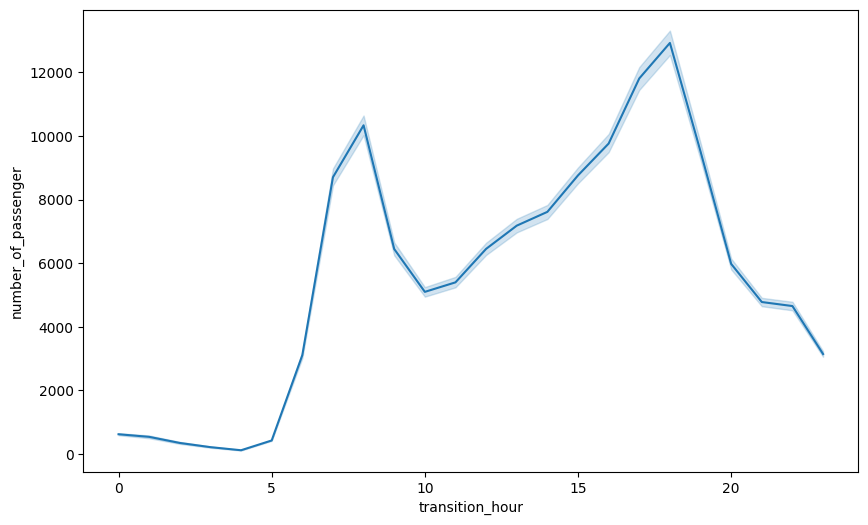

In [48]:
#lets plot the number of passengers by hour
plt.figure(figsize=(10,6))
sns.lineplot(data = df_2023, x = "transition_hour", y = "number_of_passenger")

In [49]:
#lets also focus on 06:00-00.00
df_2023 = df_2023[df_2023["transition_hour"]>=6]

In [50]:
unistats(df_2023)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
transition_date,130919,0,359,datetime64[ns],-,-,-,-,-,-,-,-,-,-
transition_hour,130919,0,18,int64,18,14.364447,6,10.0,14.0,19.0,23,5.065923,0.011706,-1.178858
number_of_passenger,130919,0,29976,int64,1,7434.566656,1,325.0,1585.0,11226.0,81250,10735.608193,1.966207,4.2835
is_weather_rainy,130919,0,2,int64,0,0.141828,0,0.0,0.0,0.0,1,0.348875,2.053327,2.216185
is_weather_windy,130919,0,2,int64,1,0.721545,0,0.0,1.0,1.0,1,0.44824,-0.988527,-1.02283
gs_match,130919,0,2,int64,0,0.044012,0,0.0,0.0,0.0,1,0.205122,4.446076,17.767866
fb_match,130919,0,2,int64,0,0.044149,0,0.0,0.0,0.0,1,0.205428,4.438129,17.697256
bjk_match,130919,0,2,int64,0,0.043821,0,0.0,0.0,0.0,1,0.204697,4.457174,17.866672
is_public_holiday,130919,0,2,int64,0,0.038413,0,0.0,0.0,0.0,1,0.192192,4.803466,21.073608
any_match,130919,0,2,int64,0,0.109862,0,0.0,0.0,0.0,1,0.312719,2.495177,4.225971


In [51]:
#lets add the season
df_2023["season"] = df_2023["transition_date"].dt.month

In [52]:
df_2023.head()

,transition_date,transition_hour,line,number_of_passenger,is_weather_rainy,is_weather_windy,gs_match,fb_match,bjk_match,is_public_holiday,any_match,match_intensity,number_of_passenger_lag,number_of_passenger_rolling_mean,day_of_week,season
159,2023-01-01,6,KIRAZLI-BASAKSEHIR/METROKENT,337,0,1,0,0,0,1,0,0,NaN,NaN,Sunday,1
160,2023-01-01,6,BAHARIYE-OLIMPIYAT,134,0,1,0,0,0,1,0,0,NaN,NaN,Sunday,1
162,2023-01-01,6,YENIKAPI - HAVALIMANI,3156,0,1,0,0,0,1,0,0,NaN,NaN,Sunday,1
164,2023-01-01,6,YENIKAPI - HACIOSMAN,4087,0,1,0,0,0,1,0,0,NaN,NaN,Sunday,1
166,2023-01-01,6,HALKALI - GEBZE,4312,0,1,0,0,0,1,0,0,NaN,NaN,Sunday,1


# Modelling and PreProcess

## Preprocess

In [53]:
df_dummied = pd.get_dummies(df_2023, columns = ["season","line","day_of_week","transition_hour"],dtype=int)
df_dummied.dropna(inplace = True)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_dummied.drop(columns = ["number_of_passenger","transition_date"]),df_dummied["number_of_passenger"],test_size = 0.2,random_state = 42)

## Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(mean_absolute_error(y_test,model.predict(X_test)))

3249.9946564690617


In [60]:
#lets fit a linear regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [61]:
sm.OLS(y_train,X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     number_of_passenger   R-squared:                       0.810
Model:                             OLS   Adj. R-squared:                  0.810
Method:                  Least Squares   F-statistic:                     6914.
Date:                 Wed, 24 Jul 2024   Prob (F-statistic):               0.00
Time:                         19:52:13   Log-Likelihood:            -1.0279e+06
No. Observations:               104124   AIC:                         2.056e+06
Df Residuals:                   104059   BIC:                         2.057e+06
Df Model:                           64                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
is_weather_rainy                        -254.0251     43.202     -5.880      0.000    -338.701    -169.350
is_weather_windy                         -76.6639     33.680     -2.276      0.023    -142.676     -10.651
gs_match                                 -12.3024     71.687     -0.172      0.864    -152.808     128.203
fb_match                                 -37.9467     73.652     -0.515      0.606    -182.303     106.410
bjk_match                                117.7870     71.040      1.658      0.097     -21.451     257.025
is_public_holiday                        364.2314     81.813      4.452      0.000     203.878     524.584
any_match                                -44.3552    137.917     -0.322      0.748    -314.671     225.961
match_intensity                           67.5379     78.303      0.863      0.388     -85.935     221.011
number_of_passenger_lag                   -0.0345      0.003    -12.943      0.000      -0.040      -0.029
number_of_passenger_rolling_mean           0.6528      0.008     79.079      0.000       0.637       0.669
season_1                                 822.2894     52.211     15.749      0.000     719.957     924.622
season_2                                 439.7050     51.002      8.621      0.000     339.742     539.668
season_3                                 661.3704     49.093     13.472      0.000     565.150     757.591
season_4                                 701.4992     54.033     12.983      0.000     595.595     807.403
season_5                                 819.0759     49.978     16.389      0.000     721.120     917.032
season_6                                 602.6180     49.991     12.054      0.000     504.636     700.600
season_7                                 373.5145     49.816      7.498      0.000     275.876     471.153
season_8                                 292.2816     49.523      5.902      0.000     195.217     389.347
season_9                                 765.0241     50.076     15.277      0.000     666.875     863.173
season_10                               1440.8045     52.611     27.386      0.000    1337.687    1543.922
season_11                               1148.5521     52.162     22.019      0.000    1046.316    1250.788
season_12                               1194.9103     51.150     23.361      0.000    1094.656    1295.165
line_BAHARIYE-OLIMPIYAT                -2121.0003     71.956    -29.476      0.000   -2262.033   -1979.968
line_BEYOGLU-TAKSIM                    -3112.1047     78.654    -39.567      0.000   -3266.265   -2957.945
line_BOSTANCI - DUDULLU                -1649.3829     68.788    -23.978      0.000   -1784.206   -1514.559
line_CEVIZLIBAG - SOGUTLUCESME          4.037e-12   6.42e-14     62.926     

In [62]:
model.predict(X_test[1:2])

array([110.49429437])

In [63]:
print(r2_score(y_test,model.predict(X_test)))

0.8090944237081295


In [64]:
print(mean_absolute_error(y_test,model.predict(X_test)))

3249.9946564690617


In [65]:
model.feature_names_in_

array(['is_weather_rainy', 'is_weather_windy', 'gs_match', 'fb_match',
       'bjk_match', 'is_public_holiday', 'any_match', 'match_intensity',
       'number_of_passenger_lag', 'number_of_passenger_rolling_mean',
       'season_1', 'season_2', 'season_3', 'season_4', 'season_5',
       'season_6', 'season_7', 'season_8', 'season_9', 'season_10',
       'season_11', 'season_12', 'line_BAHARIYE-OLIMPIYAT',
       'line_BEYOGLU-TAKSIM', 'line_BOSTANCI - DUDULLU',
       'line_CEVIZLIBAG - SOGUTLUCESME ', 'line_EMINONU-ALIBEYKOY',
       'line_EYUP - PIYERLOTI', 'line_GAYRETTEPE-ISTANBUL YENI HAVALIMA',
       'line_HALKALI - GEBZE', 'line_HALKALI-BAHCESEHIR',
       'line_KABATAS-BAGCILAR', 'line_KABATAS-MAHMUTBEY',
       'line_KADIKOY - MODA', 'line_KADIKOY-KARTAL',
       'line_KIRAZLI-BASAKSEHIR/METROKENT', 'line_LEVENT-HISAR USTU',
       'line_MACKA - TASKISLA', 'line_RUMELI HISARUSTU -ASIYAN',
       'line_TAKSIM - KABATAS', 'line_TOPKAPI-HABIBLER', 'line_TUNEL',
       'line_USKU

## Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
model2 = RandomForestRegressor()
model2.fit(X_train,y_train)
print(model2.score(X_test,y_test))

0.9779663246561855


In [80]:
print(mean_absolute_error(y_test,model2.predict(X_test)))

621.0557398586355


<Axes: xlabel='number_of_passenger'>

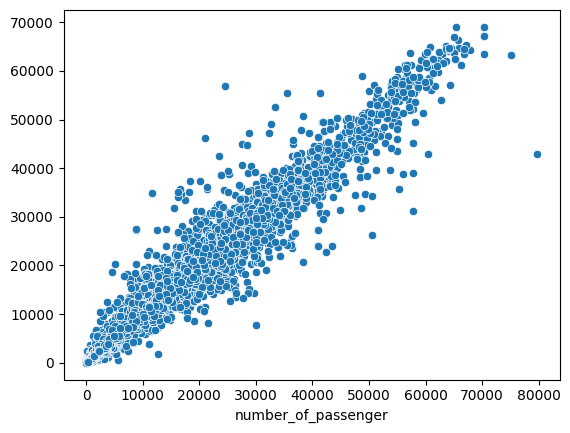

In [68]:
sns.scatterplot(x = y_test, y = model2.predict(X_test))

## XGBoost

In [71]:
from xgboost import XGBRegressor

In [72]:
model_4 = XGBRegressor()
model_4.fit(X_train,y_train)
print(model_4.score(X_test,y_test))
print(mean_absolute_error(y_test,model_4.predict(X_test)))

0.9800247493623258
751.4183780375156


## PCA

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [74]:
model_5 = PCA()
model_5.fit(X_train)

PCA()

In [77]:
pipe = Pipeline([("scaler",StandardScaler()),("pca",PCA()),("model",XGBRegressor())])

In [78]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [79]:
print(pipe.score(X_test,y_test))

0.9753451288480456


In [81]:
print(mean_absolute_error(y_test,pipe.predict(X_test)))

885.8654464928899


## Lasso and Ridge

In [82]:
from sklearn.linear_model import Lasso, Ridge


In [83]:
model_6 = Lasso()
model_6.fit(X_train,y_train)
print(model_6.score(X_test,y_test))
print(mean_absolute_error(y_test,model_6.predict(X_test)))

0.8089597532592556
3242.950126968422


In [84]:
model_7 = Ridge()
model_7.fit(X_train,y_train)
print(model_7.score(X_test,y_test))
print(mean_absolute_error(y_test,model_7.predict(X_test)))

0.8090890427147269
3249.8170823287724


## SVR

In [86]:
from sklearn.svm import SVR

In [87]:
model_8 = SVR()
model_8.fit(X_train,y_train)
print(model_8.score(X_test,y_test))
print(mean_absolute_error(y_test,model_8.predict(X_test)))

0.5215129091446555
3537.496453409115


## Neural Network

In [88]:
from sklearn.neural_network import MLPRegressor

In [89]:
model_9 = MLPRegressor()
model_9.fit(X_train,y_train)
print(model_9.score(X_test,y_test))
print(mean_absolute_error(y_test,model_9.predict(X_test)))

0.9388525015251086
1375.6989410727415


## Boosting

In [90]:
from sklearn.ensemble import GradientBoostingRegressor

In [91]:
model_10 = GradientBoostingRegressor()
model_10.fit(X_train,y_train)
print(model_10.score(X_test,y_test))
print(mean_absolute_error(y_test,model_10.predict(X_test)))

0.9205257486658635
1688.3948580261294


# Optimization

In [133]:
#Parameters
t = 18 #number of hours
y_k = 105 #number of vagons in yenikapi-kirazli
y_h = 192 #number of vagons in yenikapi-haciosman
k_m = 80 #number of vagons in kirazli-metrokent-bahariye-olimpiyat
k_s = 114 #number of vagons in kadıköy sabiha gökçen
u_c = 150 #number of vagons in üsküdar-çekmeköy
y_m = 80 #yıldız-mahmutbey
b_p = 40 #bostancı-parseller
k_b = 92 #kabataş-bağcılar
c = 896.52 #cost per vagon per hour
cap = 10000 #capacity of vagons

In [119]:
predicted_usage = model2.predict(X_test[X_test["line_YENIKAPI - HACIOSMAN"]==1][:18])

In [120]:
from gurobipy import Model, GRB

In [135]:
m = Model()

In [136]:
x = m.addVars(t, vtype = GRB.INTEGER, name="number_of_vagons")

In [137]:
m.setObjective(sum(x[i]*c for i in range(t)))

In [138]:
m.addConstrs(x[i] <= cap for i in range(t))
m.addConstrs(x[i] * cap >= predicted_usage[i] for i in range(t))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>}

In [139]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 36 rows, 18 columns and 36 nonzeros
Model fingerprint: 0xe59bd42a
Variable types: 0 continuous, 18 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [9e+02, 9e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+03, 5e+04]
Found heuristic solution: objective 40343.400000
Presolve removed 36 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 40343.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.034340000000e+04, best bound 4.034340000000e+04, gap 0.0000%


In [162]:
m.printAttr('X')
optimal_sol = m.getAttr('X')


    Variable            X 
-------------------------
number_of_vagons[0]            2 
number_of_vagons[1]            3 
number_of_vagons[2]            5 
number_of_vagons[3]            4 
number_of_vagons[4]            1 
number_of_vagons[5]            1 
number_of_vagons[6]            3 
number_of_vagons[7]            3 
number_of_vagons[8]            2 
number_of_vagons[9]            3 
number_of_vagons[10]            3 
number_of_vagons[11]            1 
number_of_vagons[12]            3 
number_of_vagons[13]            2 
number_of_vagons[14]            3 
number_of_vagons[15]            2 
number_of_vagons[16]            3 
number_of_vagons[17]            1 


In [141]:
predicted_usage

array([10254.58, 22907.12, 48357.29, 35418.24,  9945.52,  8962.2 ,
       20603.46, 24542.83, 10447.26, 24216.27, 26883.75,  9436.77,
       29873.43, 18861.26, 22733.63, 10815.31, 29846.13,  3522.56])

In [164]:
#if we use 5 vagons all the time
cost_old = 5*c*t
cost_new = sum(optimal_sol[i]*c for i in range(t))
print(cost_old)
print(cost_new)

80686.8
40343.4
